In [2]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import scipy
import pyDOE
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from net.models import NN

In [3]:
# CUDA 사용 가능한지 확인합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [4]:
tasks = glob("./data/*.npy")
tasks

['./data/train_0.882821876481688_0.6111822228604451_0.7286163354114135_.npy',
 './data/train_0.9926610113369381_1.0044676920990128_1.0638761184602317_.npy',
 './data/train_1.0600509553624107_1.80363778828612_0.8063141203855428_.npy',
 './data/train_0.8056793994939285_1.667088624340879_0.6558453062090482_.npy',
 './data/train_1.1142205550249682_1.551663418732249_1.8841221939248038_.npy',
 './data/train_1.0113005341300303_1.1042978763708164_0.9825942665038673_.npy',
 './data/train_0.7807992483360096_1.2503325654877329_0.6434790402413546_.npy',
 './data/train_0.7170707652711635_1.2481880765132585_1.5748870026040955_.npy',
 './data/train_0.564789328106174_1.5367085495967512_1.9498958056687643_.npy',
 './data/train_1.4414725726351811_0.9122516777264776_1.405664910808274_.npy',
 './data/train_0.6964663563181073_0.8714126073073516_0.8858933764210435_.npy',
 './data/train_0.5286829503741566_1.9697624738125876_1.8280660150877082_.npy',
 './data/train_1.1550933504346717_1.3479038854802354_1.2269

In [5]:
def compute_derivatives(model, xy_data):
    xy_data = xy_data.to(device)
    # Ensure that xy_data has gradient information.
    xy_data.requires_grad_(True)
    
    # Get the model prediction.
    f_pred = model(xy_data)
    
    # Create a tensor of ones with the same shape as f_pred to be used for gradient computation.
    # Reshape the ones tensor to match the shape of f_pred.
    ones = torch.ones(f_pred.shape, device=device, requires_grad=False)
    
    # Compute the first derivatives.
    f_x = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 0]
    f_y = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 1]
    
    # Compute the second derivatives.
    f_xx = torch.autograd.grad(f_x, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 0]
    f_yy = torch.autograd.grad(f_y, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 1]
    
    return f_xx, f_yy

In [6]:
# 손실 함수를 정의합니다.
def pinn_loss(model, criterion, xy_data, f_data, alpha=0.1, A=1,B=1,C=1):
    f_pred = model(xy_data)
    data_loss = criterion(f_pred, f_data)
    f_xx, f_yy = compute_derivatives(model, xy_data)
    pde_loss = criterion(f_xx + f_yy, -A*(B*B+C*C)*f_pred.squeeze())
    return data_loss + alpha * pde_loss

In [7]:
# 배치학습을 위한 데이터 로더 함수를 정의합니다.
def create_dataloader(x_data, y_data, batch_size, shuffle):
    dataset = TensorDataset(x_data, y_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [8]:
def train_model(model, epochs, A, B, C):
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss

        for batch_xy, batch_f in loader:
            batch_xy, batch_f = batch_xy.to(device), batch_f.to(device)
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            pde_loss = criterion(f_xx + f_yy, -(B*B+C*C)*f_pred.squeeze())

            # Combine the losses
            loss = data_loss + alpha * pde_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()

        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)

        scheduler.step(avg_loss)

        # Print the losses every 100 epochs
        if epoch % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}, Total Loss: {avg_loss}, Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, LR: {current_lr}')

    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()
    return model

In [16]:
def test_inference(model, test_data_path):
    with open(test_data_path, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)

    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    return loss

In [10]:
# 하이퍼 파라미터
batch_size = 5000
shuffle = True # 데이터 셔플
epochs = 2000   # 훈련 epoch
alpha=0.5      # Total Loss = Data Loss + alpha * PDE Loss

/tmp/ipykernel_3661/3180674654.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_data = torch.tensor(f_data.ravel(), dtype=torch.float).view(-1, 1)


training with A:0.8828218579292297 B:0.6111822128295898 C:0.7286163568496704
Epoch 0/2000, Total Loss: 0.29588815569877625, Data Loss: 0.29092830419540405, PDE Loss: 0.009919694624841213, LR: 0.02
Epoch 50/2000, Total Loss: 0.015869230031967163, Data Loss: 0.0027905709575861692, PDE Loss: 0.0261573176831007, LR: 0.02
Epoch 100/2000, Total Loss: 0.013865221291780472, Data Loss: 0.004178094677627087, PDE Loss: 0.01937425322830677, LR: 0.02
Epoch 150/2000, Total Loss: 0.011452822014689445, Data Loss: 0.002603678498417139, PDE Loss: 0.017698287963867188, LR: 0.004801999999999998
Epoch 200/2000, Total Loss: 0.010310129262506962, Data Loss: 0.002330780727788806, PDE Loss: 0.015958696603775024, LR: 0.004801999999999998
Epoch 250/2000, Total Loss: 0.009530273266136646, Data Loss: 0.002288898453116417, PDE Loss: 0.014482749626040459, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.008764123544096947, Data Loss: 0.0022440829779952765, PDE Loss: 0.013040081597864628, LR: 0.0048019999999999

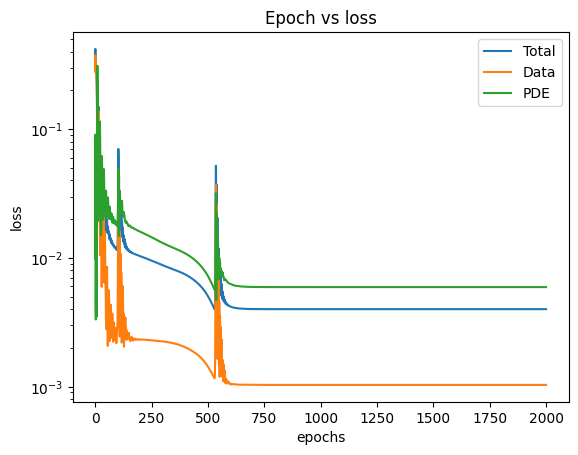

Train end


Test MSE Loss :  0.12401762493964852


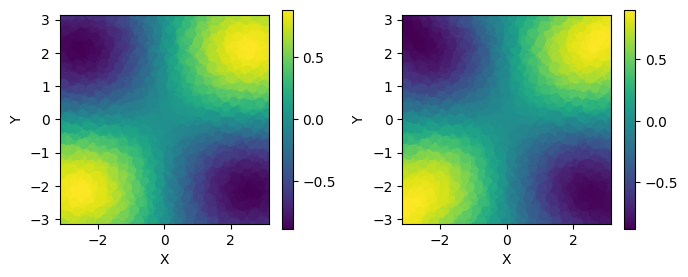

training with A:0.9926609992980957 B:1.0044677257537842 C:1.0638761520385742
Epoch 0/2000, Total Loss: 0.267078697681427, Data Loss: 0.239342600107193, PDE Loss: 0.05547216534614563, LR: 0.02
Epoch 50/2000, Total Loss: 0.1238541379570961, Data Loss: 0.08162963390350342, PDE Loss: 0.08444900810718536, LR: 0.02
Epoch 100/2000, Total Loss: 0.06662550568580627, Data Loss: 0.03308165818452835, PDE Loss: 0.06708769500255585, LR: 0.02
Epoch 150/2000, Total Loss: 0.05984707921743393, Data Loss: 0.02735881879925728, PDE Loss: 0.0649765208363533, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.013737490400671959, Data Loss: 0.006308922544121742, PDE Loss: 0.014857134781777859, LR: 0.004801999999999998
Epoch 250/2000, Total Loss: 0.007228994742035866, Data Loss: 0.003467859234660864, PDE Loss: 0.0075222705490887165, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.005366498604416847, Data Loss: 0.002495615044608712, PDE Loss: 0.005741767585277557, LR: 0.0033613999999999983
Epoch 350/

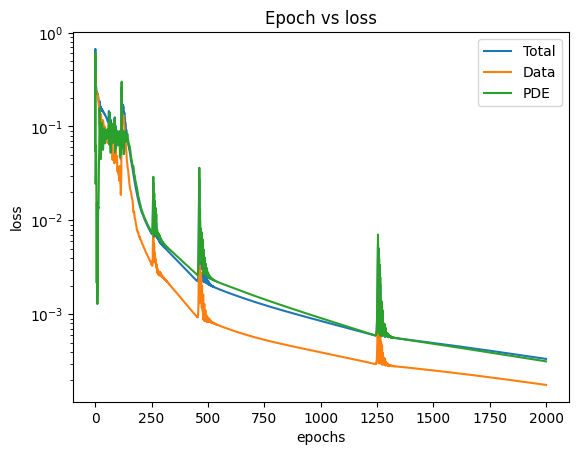

Train end


Test MSE Loss :  0.04721757113364802


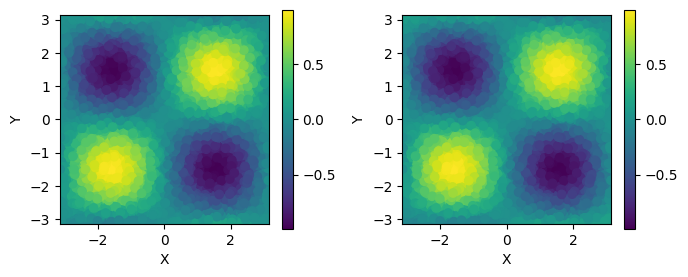

training with A:1.0600509643554688 B:1.8036377429962158 C:0.8063141107559204
Epoch 0/2000, Total Loss: 0.4622713029384613, Data Loss: 0.37015652656555176, PDE Loss: 0.1842295527458191, LR: 0.02
Epoch 50/2000, Total Loss: 0.33310678601264954, Data Loss: 0.3228776752948761, PDE Loss: 0.020458247512578964, LR: 0.02
Epoch 100/2000, Total Loss: 0.2873930335044861, Data Loss: 0.2598382234573364, PDE Loss: 0.05510960519313812, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.1611766815185547, Data Loss: 0.11476247012615204, PDE Loss: 0.09282843768596649, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.0738341212272644, Data Loss: 0.032622940838336945, PDE Loss: 0.08242236077785492, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.042443789541721344, Data Loss: 0.017188958823680878, PDE Loss: 0.05050966143608093, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.05384523794054985, Data Loss: 0.014818920753896236, PDE Loss: 0.07805263251066208, LR: 0.004801999999999998
E

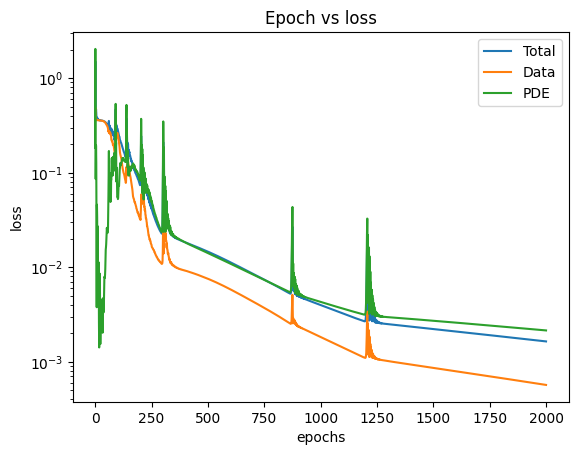

Train end


Test MSE Loss :  0.09973008849288029


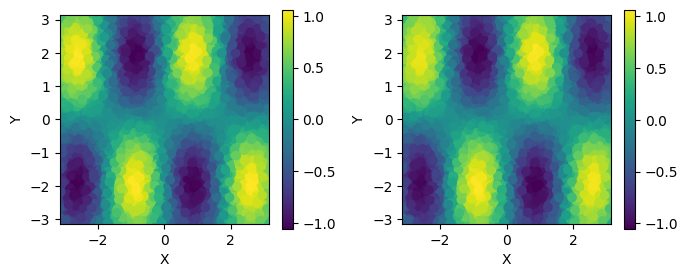

training with A:0.8056793808937073 B:1.6670886278152466 C:0.6558452844619751
Epoch 0/2000, Total Loss: 0.28655850887298584, Data Loss: 0.22429955005645752, PDE Loss: 0.12451793998479843, LR: 0.02
Epoch 50/2000, Total Loss: 0.1894238442182541, Data Loss: 0.18170277774333954, PDE Loss: 0.015442144125699997, LR: 0.02
Epoch 100/2000, Total Loss: 0.17900574207305908, Data Loss: 0.14455698430538177, PDE Loss: 0.06889750063419342, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.06193771958351135, Data Loss: 0.02609732560813427, PDE Loss: 0.07168078422546387, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.03335297480225563, Data Loss: 0.011990189552307129, PDE Loss: 0.042725570499897, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.026248812675476074, Data Loss: 0.008382701314985752, PDE Loss: 0.035732220858335495, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.00962265208363533, Data Loss: 0.0034143419470638037, PDE Loss: 0.01241662073880434, LR: 0.00480199999999

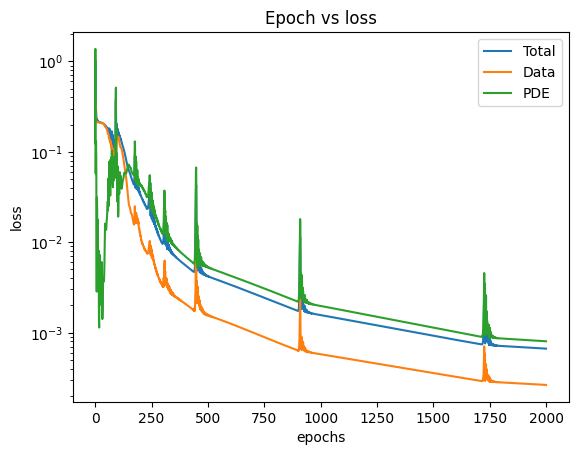

Train end


Test MSE Loss :  0.07221700960511798


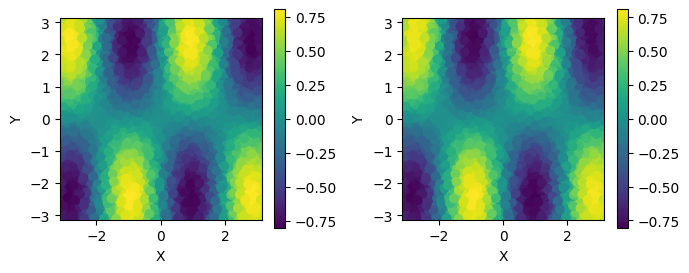

training with A:1.1142204999923706 B:1.5516633987426758 C:1.8841222524642944
Epoch 0/2000, Total Loss: 0.5655731558799744, Data Loss: 0.3512600362300873, PDE Loss: 0.4286262094974518, LR: 0.02
Epoch 50/2000, Total Loss: 0.3379232883453369, Data Loss: 0.33683842420578003, PDE Loss: 0.002169739454984665, LR: 0.02
Epoch 100/2000, Total Loss: 0.33230268955230713, Data Loss: 0.32961511611938477, PDE Loss: 0.005375159438699484, LR: 0.02
Epoch 150/2000, Total Loss: 0.32090452313423157, Data Loss: 0.3132963180541992, PDE Loss: 0.01521642878651619, LR: 0.009799999999999998
Epoch 200/2000, Total Loss: 0.3024922311306, Data Loss: 0.2716739773750305, PDE Loss: 0.06163649633526802, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.27480947971343994, Data Loss: 0.25247541069984436, PDE Loss: 0.04466812685132027, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.2509928345680237, Data Loss: 0.20598937571048737, PDE Loss: 0.09000692516565323, LR: 0.004801999999999998
Epoch 350/2000, Total Lo

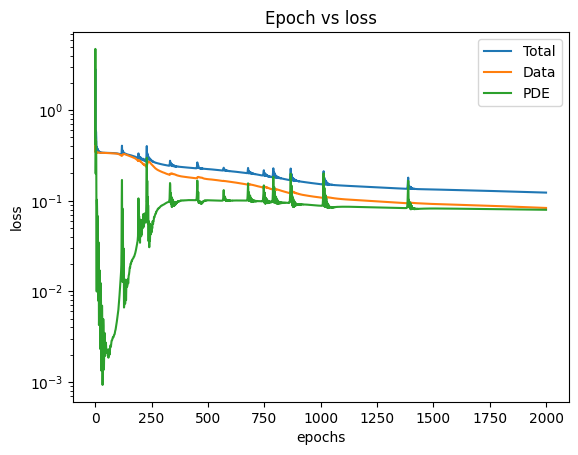

Train end


Test MSE Loss :  0.39957753131812346


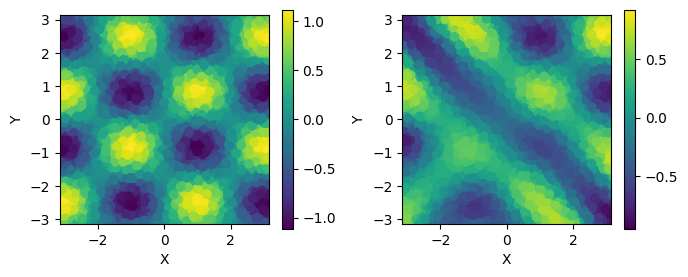

training with A:1.0113005638122559 B:1.1042978763580322 C:0.9825942516326904
Epoch 0/2000, Total Loss: 0.2770373225212097, Data Loss: 0.24816659092903137, PDE Loss: 0.0577414408326149, LR: 0.02
Epoch 50/2000, Total Loss: 0.13486497104167938, Data Loss: 0.08555278182029724, PDE Loss: 0.09862437099218369, LR: 0.02
Epoch 100/2000, Total Loss: 0.07287563383579254, Data Loss: 0.03816699609160423, PDE Loss: 0.06941726803779602, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.01970631070435047, Data Loss: 0.007379819173365831, PDE Loss: 0.024652983993291855, LR: 0.009799999999999998
Epoch 200/2000, Total Loss: 0.007296293042600155, Data Loss: 0.003387753153219819, PDE Loss: 0.007817079313099384, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.00694387499243021, Data Loss: 0.0027504251338541508, PDE Loss: 0.008386899717152119, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.004320299718528986, Data Loss: 0.00173623685259372, PDE Loss: 0.005168125499039888, LR: 0.0033613999

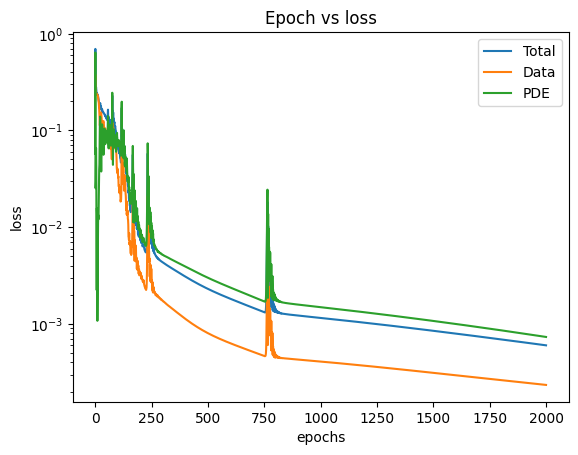

Train end


Test MSE Loss :  0.05600913988941816


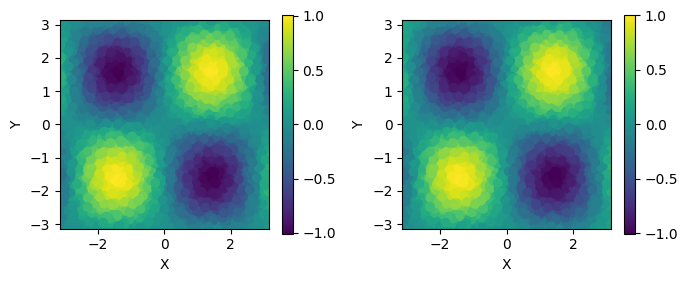

training with A:0.7807992696762085 B:1.2503325939178467 C:0.64347904920578
Epoch 0/2000, Total Loss: 0.19369983673095703, Data Loss: 0.1700490117073059, PDE Loss: 0.04730165749788284, LR: 0.02
Epoch 50/2000, Total Loss: 0.09480968862771988, Data Loss: 0.06361542642116547, PDE Loss: 0.062388528138399124, LR: 0.02
Epoch 100/2000, Total Loss: 0.03654571622610092, Data Loss: 0.016005532816052437, PDE Loss: 0.04108036309480667, LR: 0.02
Epoch 150/2000, Total Loss: 0.00993604026734829, Data Loss: 0.0036515251267701387, PDE Loss: 0.012569030746817589, LR: 0.009799999999999998
Epoch 200/2000, Total Loss: 0.006686039734631777, Data Loss: 0.0016979110660031438, PDE Loss: 0.00997625757008791, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.001709966454654932, Data Loss: 0.00020342992502264678, PDE Loss: 0.0030130730010569096, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.0012158347526565194, Data Loss: 0.00011997748515568674, PDE Loss: 0.0021917144767940044, LR: 0.0048019999999999

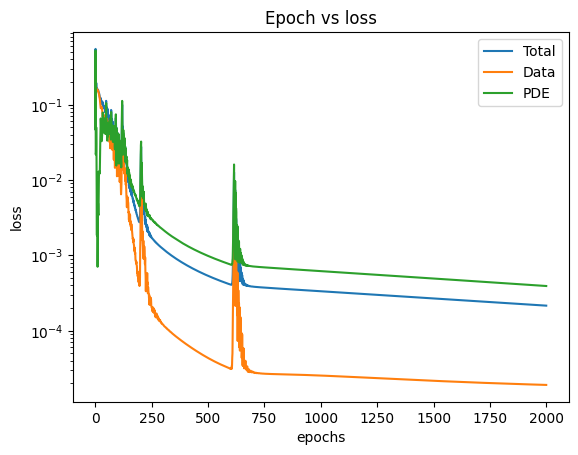

Train end


Test MSE Loss :  0.03332011621347582


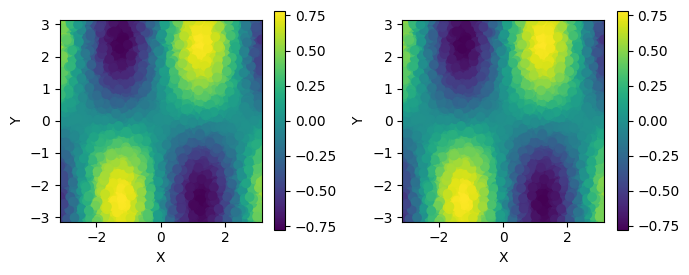

training with A:0.7170707583427429 B:1.2481880187988281 C:1.5748870372772217
Epoch 0/2000, Total Loss: 0.22725112736225128, Data Loss: 0.12871330976486206, PDE Loss: 0.19707563519477844, LR: 0.02
Epoch 50/2000, Total Loss: 0.1145295575261116, Data Loss: 0.11360031366348267, PDE Loss: 0.001858485396951437, LR: 0.02
Epoch 100/2000, Total Loss: 0.1005549356341362, Data Loss: 0.09312216937541962, PDE Loss: 0.014865539036691189, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.07995858788490295, Data Loss: 0.06222417950630188, PDE Loss: 0.03546880930662155, LR: 0.009799999999999998
Epoch 200/2000, Total Loss: 0.07899915426969528, Data Loss: 0.05957753211259842, PDE Loss: 0.038843248039484024, LR: 0.002352979999999999
Epoch 250/2000, Total Loss: 0.072067990899086, Data Loss: 0.051344748586416245, PDE Loss: 0.041446488350629807, LR: 0.002352979999999999
Epoch 300/2000, Total Loss: 0.06503131240606308, Data Loss: 0.043810781091451645, PDE Loss: 0.04244105890393257, LR: 0.0023529799999999

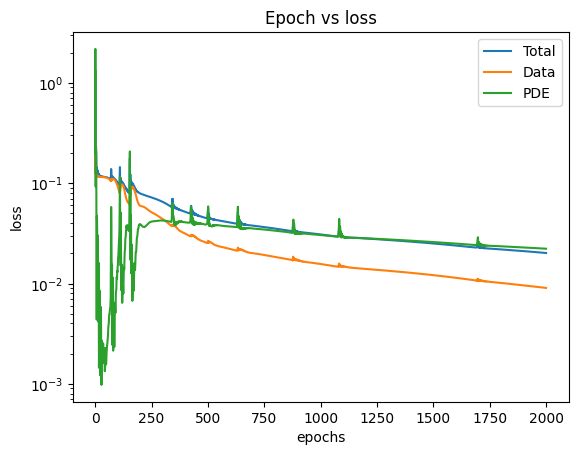

Train end


Test MSE Loss :  0.16553919852057355


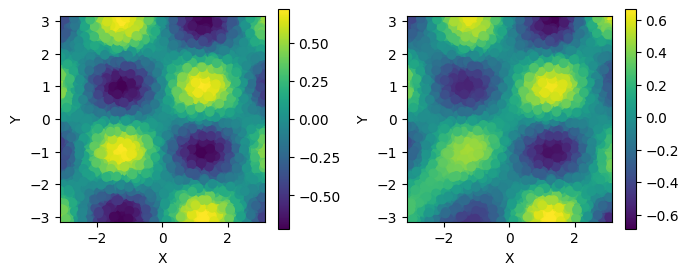

training with A:0.564789354801178 B:1.5367085933685303 C:1.9498958587646484
Epoch 0/2000, Total Loss: 0.3245795667171478, Data Loss: 0.09510394185781479, PDE Loss: 0.45895126461982727, LR: 0.02
Epoch 50/2000, Total Loss: 0.08408500254154205, Data Loss: 0.08384038507938385, PDE Loss: 0.0004892348661087453, LR: 0.02
Epoch 100/2000, Total Loss: 0.08354510366916656, Data Loss: 0.08312375843524933, PDE Loss: 0.0008426851127296686, LR: 0.02
Epoch 150/2000, Total Loss: 0.08178479224443436, Data Loss: 0.08041977137327194, PDE Loss: 0.002730047330260277, LR: 0.02
Epoch 200/2000, Total Loss: 0.08336985111236572, Data Loss: 0.08317592740058899, PDE Loss: 0.00038784625940024853, LR: 0.004801999999999998
Epoch 250/2000, Total Loss: 0.0826796442270279, Data Loss: 0.08240094780921936, PDE Loss: 0.0005573973758146167, LR: 0.0011529601999999994
Epoch 300/2000, Total Loss: 0.0825168788433075, Data Loss: 0.08217470347881317, PDE Loss: 0.0006843454902991652, LR: 0.00019377802081399983
Epoch 350/2000, Tota

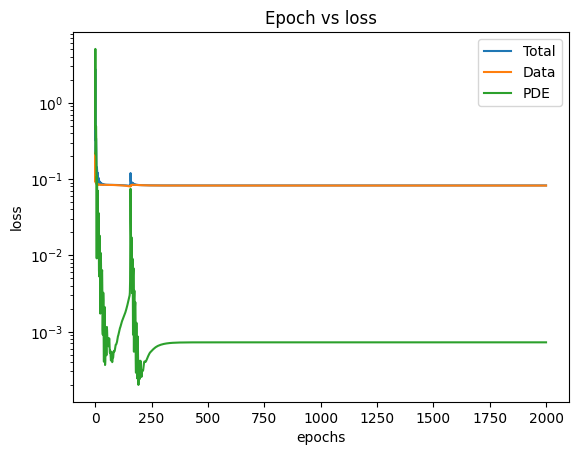

Train end


Test MSE Loss :  0.23726807378483145


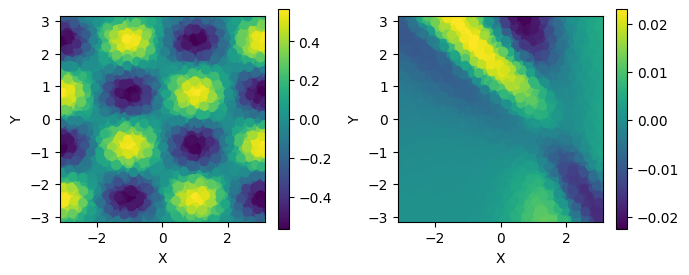

training with A:1.4414725303649902 B:0.9122516512870789 C:1.4056649208068848
Epoch 0/2000, Total Loss: 0.5961524844169617, Data Loss: 0.5485032200813293, PDE Loss: 0.09529856592416763, LR: 0.02
Epoch 50/2000, Total Loss: 0.4488469660282135, Data Loss: 0.4144461452960968, PDE Loss: 0.06880165636539459, LR: 0.013999999999999999
Epoch 100/2000, Total Loss: 0.29299628734588623, Data Loss: 0.23082004487514496, PDE Loss: 0.12435248494148254, LR: 0.009799999999999998
Epoch 150/2000, Total Loss: 0.099302738904953, Data Loss: 0.03740881755948067, PDE Loss: 0.12378785014152527, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.0682261735200882, Data Loss: 0.023590680211782455, PDE Loss: 0.08927098661661148, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.056210145354270935, Data Loss: 0.01776638813316822, PDE Loss: 0.07688751071691513, LR: 0.0033613999999999983
Epoch 300/2000, Total Loss: 0.04553067684173584, Data Loss: 0.014018320478498936, PDE Loss: 0.06302471458911896, LR: 0.00336

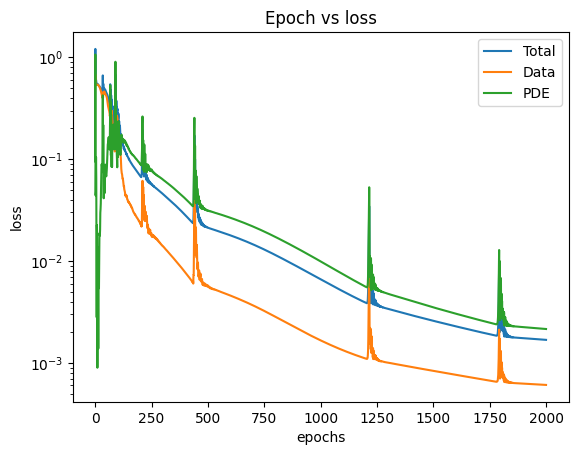

Train end


Test MSE Loss :  0.10287845273614471


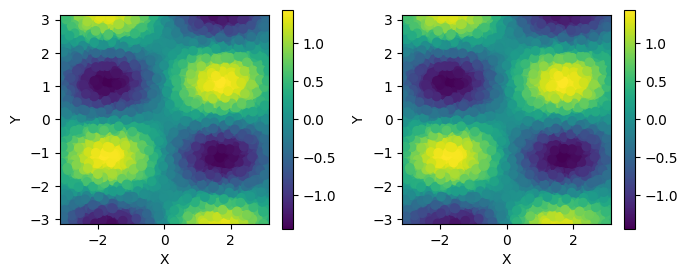

training with A:0.696466326713562 B:0.8714126348495483 C:0.8858934044837952
Epoch 0/2000, Total Loss: 0.1819555163383484, Data Loss: 0.16752596199512482, PDE Loss: 0.028859112411737442, LR: 0.02
Epoch 50/2000, Total Loss: 0.044499471783638, Data Loss: 0.02036791667342186, PDE Loss: 0.04826311394572258, LR: 0.02
Epoch 100/2000, Total Loss: 0.03736717253923416, Data Loss: 0.027169017121195793, PDE Loss: 0.020396312698721886, LR: 0.02
Epoch 150/2000, Total Loss: 0.009183578193187714, Data Loss: 0.004270144738256931, PDE Loss: 0.00982686597853899, LR: 0.009799999999999998
Epoch 200/2000, Total Loss: 0.0013819979503750801, Data Loss: 0.0003044346522074193, PDE Loss: 0.0021551265381276608, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.0006512167165055871, Data Loss: 0.00015107828949112445, PDE Loss: 0.0010002768831327558, LR: 0.009799999999999998
Epoch 300/2000, Total Loss: 0.0004005899536423385, Data Loss: 9.219365892931819e-05, PDE Loss: 0.0006167925894260406, LR: 0.00979999999999

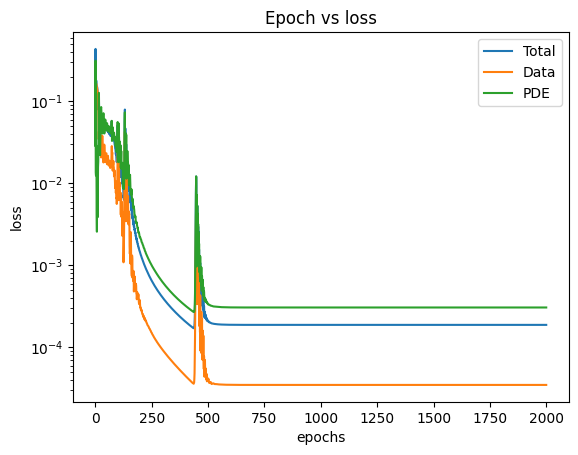

Train end


Test MSE Loss :  0.04070921892238158


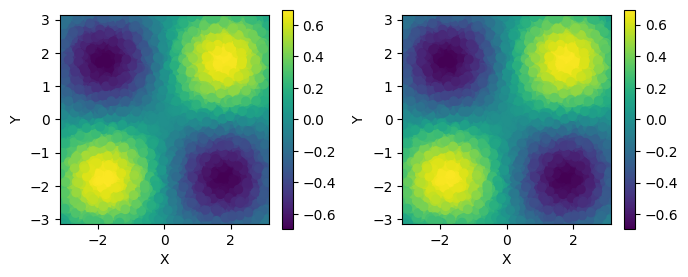

training with A:0.5286829471588135 B:1.9697624444961548 C:1.8280659914016724
Epoch 0/2000, Total Loss: 0.4034864008426666, Data Loss: 0.08846915513277054, PDE Loss: 0.6300345063209534, LR: 0.02
Epoch 50/2000, Total Loss: 0.07545627653598785, Data Loss: 0.0752621740102768, PDE Loss: 0.0003882070304825902, LR: 0.02
Epoch 100/2000, Total Loss: 0.07520261406898499, Data Loss: 0.07497727125883102, PDE Loss: 0.0004506791883613914, LR: 0.02
Epoch 150/2000, Total Loss: 0.07496421039104462, Data Loss: 0.0745585560798645, PDE Loss: 0.0008113036747090518, LR: 0.02
Epoch 200/2000, Total Loss: 0.07455772906541824, Data Loss: 0.07396607100963593, PDE Loss: 0.0011833123862743378, LR: 0.02
Epoch 250/2000, Total Loss: 0.07863221317529678, Data Loss: 0.07565388828516006, PDE Loss: 0.0059566558338701725, LR: 0.013999999999999999
Epoch 300/2000, Total Loss: 0.07553273439407349, Data Loss: 0.07551435381174088, PDE Loss: 3.6767185520147905e-05, LR: 0.002352979999999999
Epoch 350/2000, Total Loss: 0.07551937

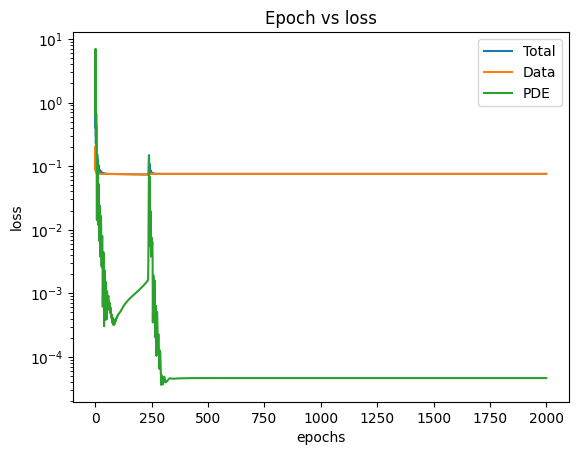

Train end


Test MSE Loss :  0.22853300202064847


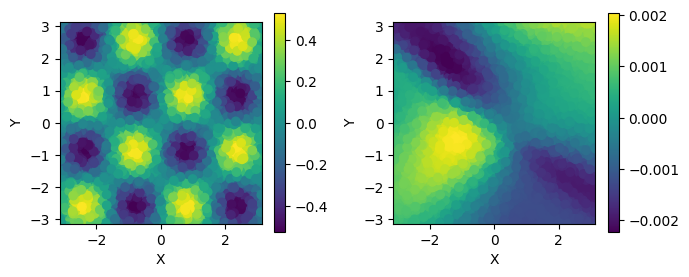

training with A:1.1550933122634888 B:1.347903847694397 C:1.2269057035446167
Epoch 0/2000, Total Loss: 0.34246957302093506, Data Loss: 0.2757377326488495, PDE Loss: 0.13346365094184875, LR: 0.02
Epoch 50/2000, Total Loss: 0.2443799525499344, Data Loss: 0.23142318427562714, PDE Loss: 0.025913527235388756, LR: 0.02
Epoch 100/2000, Total Loss: 0.22381851077079773, Data Loss: 0.20375031232833862, PDE Loss: 0.04013640806078911, LR: 0.009799999999999998
Epoch 150/2000, Total Loss: 0.1540871113538742, Data Loss: 0.1150585412979126, PDE Loss: 0.07805714756250381, LR: 0.009799999999999998
Epoch 200/2000, Total Loss: 0.12586362659931183, Data Loss: 0.07630704343318939, PDE Loss: 0.09911316633224487, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.08761011064052582, Data Loss: 0.04900559037923813, PDE Loss: 0.07720904052257538, LR: 0.006859999999999998
Epoch 300/2000, Total Loss: 0.0744430273771286, Data Loss: 0.04018857330083847, PDE Loss: 0.06850890070199966, LR: 0.0033613999999999983
Epo

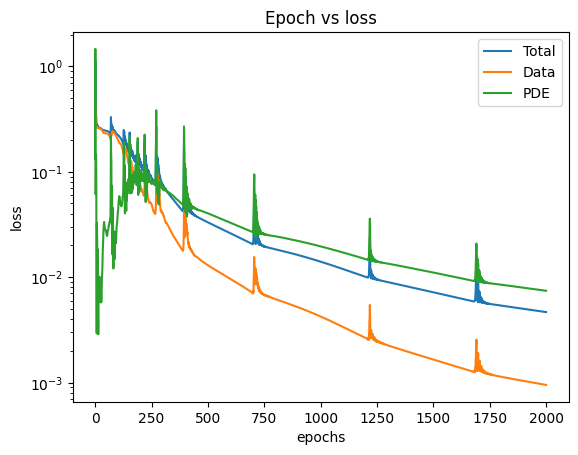

Train end


Test MSE Loss :  0.10709430859422209


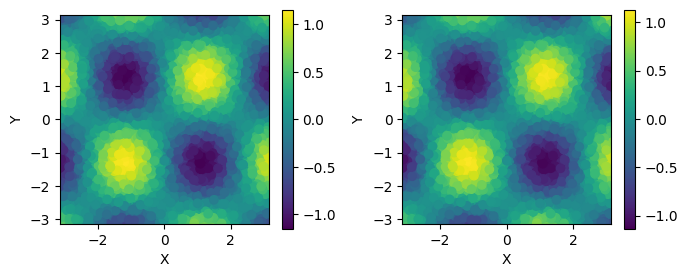

training with A:1.215064287185669 B:1.0334895849227905 C:1.3190339803695679
Epoch 0/2000, Total Loss: 0.37595900893211365, Data Loss: 0.3282758593559265, PDE Loss: 0.09536632150411606, LR: 0.02
Epoch 50/2000, Total Loss: 0.2178383767604828, Data Loss: 0.17976269125938416, PDE Loss: 0.07615138590335846, LR: 0.02
Epoch 100/2000, Total Loss: 0.09575174748897552, Data Loss: 0.056107260286808014, PDE Loss: 0.07928898185491562, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.052047666162252426, Data Loss: 0.029892265796661377, PDE Loss: 0.0443108007311821, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.035655610263347626, Data Loss: 0.017881402745842934, PDE Loss: 0.035548415035009384, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.026925615966320038, Data Loss: 0.014162585139274597, PDE Loss: 0.025526059791445732, LR: 0.006859999999999998
Epoch 300/2000, Total Loss: 0.14116793870925903, Data Loss: 0.046961985528469086, PDE Loss: 0.1884118914604187, LR: 0.0068599999999

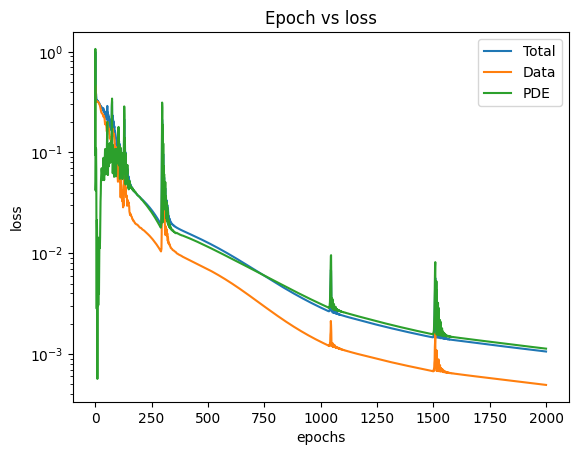

Train end


Test MSE Loss :  0.07539353998439628


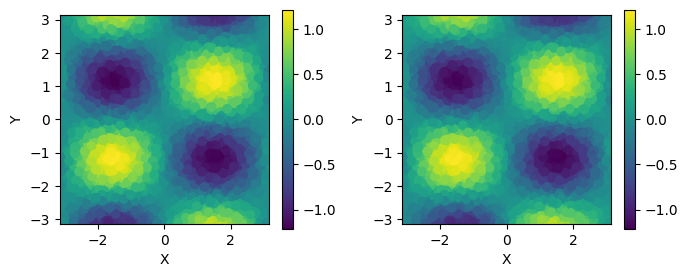

training with A:1.4652591943740845 B:1.850986361503601 C:1.7394468784332275
Epoch 0/2000, Total Loss: 0.8865383863449097, Data Loss: 0.6349761486053467, PDE Loss: 0.5031244158744812, LR: 0.02
Epoch 50/2000, Total Loss: 0.6185018420219421, Data Loss: 0.6168283224105835, PDE Loss: 0.0033470962662249804, LR: 0.02
Epoch 100/2000, Total Loss: 0.603804886341095, Data Loss: 0.5895147919654846, PDE Loss: 0.02858022414147854, LR: 0.02
Epoch 150/2000, Total Loss: 0.561762809753418, Data Loss: 0.537732720375061, PDE Loss: 0.04806017503142357, LR: 0.013999999999999999
Epoch 200/2000, Total Loss: 0.5223462581634521, Data Loss: 0.470324844121933, PDE Loss: 0.10404276847839355, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.501818060874939, Data Loss: 0.4548884630203247, PDE Loss: 0.09385916590690613, LR: 0.006859999999999998
Epoch 300/2000, Total Loss: 0.48313313722610474, Data Loss: 0.41324061155319214, PDE Loss: 0.139785036444664, LR: 0.004801999999999998
Epoch 350/2000, Total Loss: 0.4692

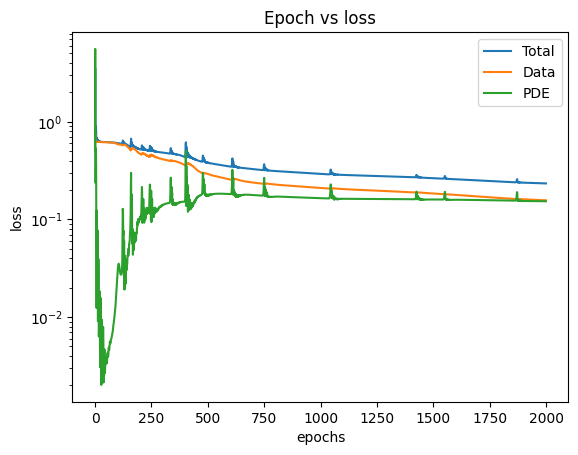

Train end


Test MSE Loss :  0.552189789268944


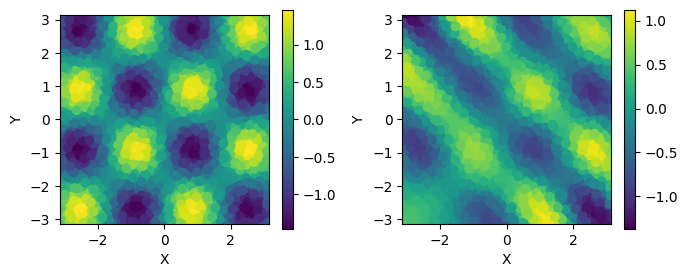

training with A:1.251629114151001 B:0.6855972409248352 C:1.155348539352417
Epoch 0/2000, Total Loss: 0.45224636793136597, Data Loss: 0.4325372874736786, PDE Loss: 0.039418138563632965, LR: 0.02
Epoch 50/2000, Total Loss: 0.19048331677913666, Data Loss: 0.10900548845529556, PDE Loss: 0.1629556566476822, LR: 0.013999999999999999
Epoch 100/2000, Total Loss: 0.08408890664577484, Data Loss: 0.048836883157491684, PDE Loss: 0.07050405442714691, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.09392097592353821, Data Loss: 0.039324358105659485, PDE Loss: 0.10919323563575745, LR: 0.0033613999999999983
Epoch 200/2000, Total Loss: 0.04897066578269005, Data Loss: 0.017835555598139763, PDE Loss: 0.06227022036910057, LR: 0.0016470859999999992
Epoch 250/2000, Total Loss: 0.02551247552037239, Data Loss: 0.008845753036439419, PDE Loss: 0.03333344683051109, LR: 0.0016470859999999992
Epoch 300/2000, Total Loss: 0.012674595229327679, Data Loss: 0.004218920134007931, PDE Loss: 0.016911350190639496, L

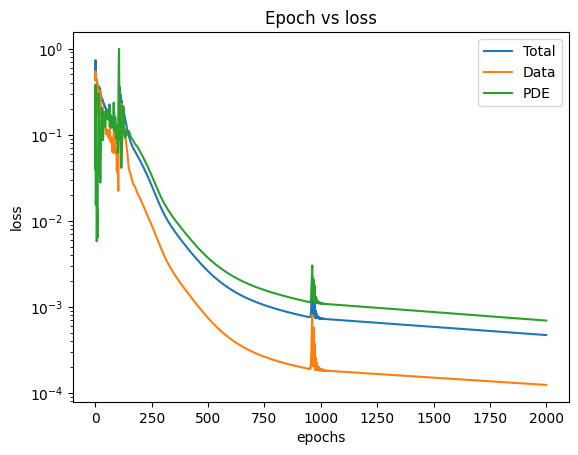

Train end


Test MSE Loss :  0.061792828745122826


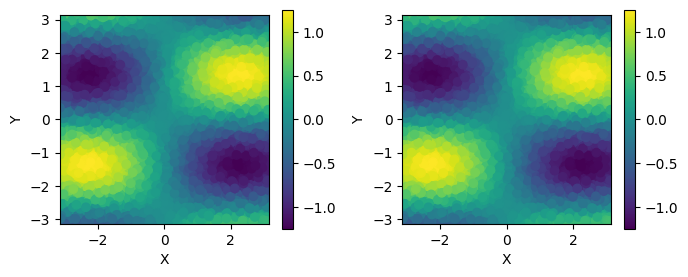

training with A:1.3793156147003174 B:1.4235602617263794 C:0.5256465673446655
Epoch 0/2000, Total Loss: 0.5126099586486816, Data Loss: 0.48053666949272156, PDE Loss: 0.06414663791656494, LR: 0.02
Epoch 50/2000, Total Loss: 0.25820228457450867, Data Loss: 0.20115600526332855, PDE Loss: 0.11409257352352142, LR: 0.02
Epoch 100/2000, Total Loss: 0.15569457411766052, Data Loss: 0.09745608270168304, PDE Loss: 0.11647699773311615, LR: 0.009799999999999998
Epoch 150/2000, Total Loss: 0.05867859721183777, Data Loss: 0.029027389362454414, PDE Loss: 0.05930241569876671, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.026567934080958366, Data Loss: 0.006572416517883539, PDE Loss: 0.03999103605747223, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.0190376415848732, Data Loss: 0.004207243211567402, PDE Loss: 0.029660798609256744, LR: 0.006859999999999998
Epoch 300/2000, Total Loss: 0.01764315366744995, Data Loss: 0.004142954479902983, PDE Loss: 0.02700039930641651, LR: 0.00235297999999

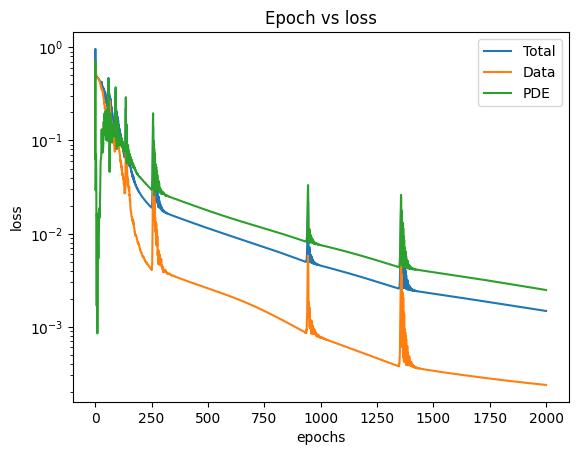

Train end


Test MSE Loss :  0.08522363664608205


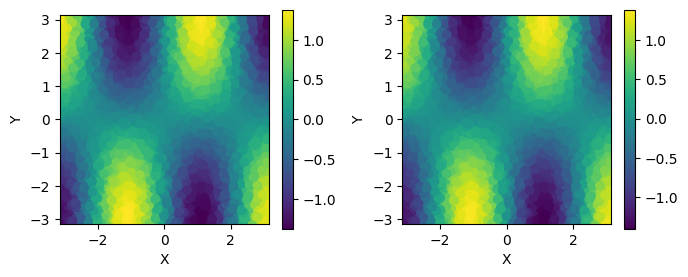

training with A:0.6461435556411743 B:0.7519879937171936 C:1.3459413051605225
Epoch 0/2000, Total Loss: 0.15911871194839478, Data Loss: 0.12495839595794678, PDE Loss: 0.068320631980896, LR: 0.02
Epoch 50/2000, Total Loss: 0.0814596638083458, Data Loss: 0.06021508201956749, PDE Loss: 0.04248916357755661, LR: 0.02
Epoch 100/2000, Total Loss: 0.04662777855992317, Data Loss: 0.03394027054309845, PDE Loss: 0.025375016033649445, LR: 0.009799999999999998
Epoch 150/2000, Total Loss: 0.011275941506028175, Data Loss: 0.004212557803839445, PDE Loss: 0.014126766473054886, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.006010721437633038, Data Loss: 0.0011873438488692045, PDE Loss: 0.009646755643188953, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.004163146484643221, Data Loss: 0.0008134540403261781, PDE Loss: 0.006699385121464729, LR: 0.006859999999999998
Epoch 300/2000, Total Loss: 0.0035880571231245995, Data Loss: 0.0007462175562977791, PDE Loss: 0.005683679133653641, LR: 0.0033

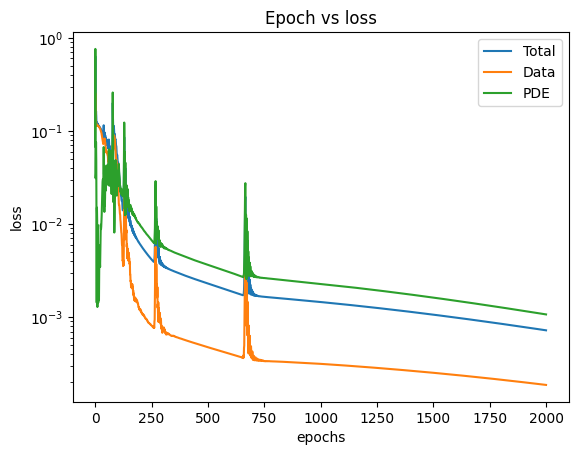

Train end


Test MSE Loss :  0.05977800421648904


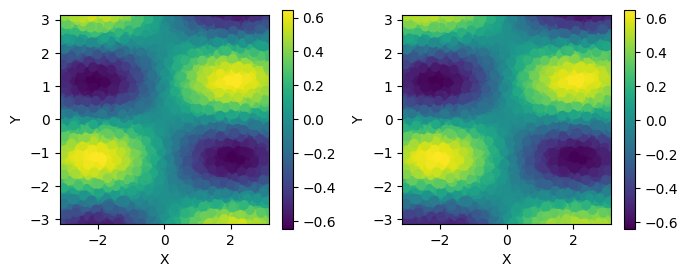

training with A:0.9481901526451111 B:1.7365808486938477 C:1.6332522630691528
Epoch 0/2000, Total Loss: 0.4743739366531372, Data Loss: 0.27911999821662903, PDE Loss: 0.39050784707069397, LR: 0.02
Epoch 50/2000, Total Loss: 0.2640199065208435, Data Loss: 0.2630075514316559, PDE Loss: 0.002024709479883313, LR: 0.013999999999999999
Epoch 100/2000, Total Loss: 0.26164036989212036, Data Loss: 0.2596346437931061, PDE Loss: 0.00401147548109293, LR: 0.013999999999999999
Epoch 150/2000, Total Loss: 0.2502380311489105, Data Loss: 0.24232091009616852, PDE Loss: 0.015834234654903412, LR: 0.013999999999999999
Epoch 200/2000, Total Loss: 0.22491240501403809, Data Loss: 0.21069638431072235, PDE Loss: 0.028432054445147514, LR: 0.009799999999999998
Epoch 250/2000, Total Loss: 0.21726356446743011, Data Loss: 0.20324133336544037, PDE Loss: 0.028044456616044044, LR: 0.0033613999999999983
Epoch 300/2000, Total Loss: 0.20611530542373657, Data Loss: 0.18247182667255402, PDE Loss: 0.04728696867823601, LR: 0.00

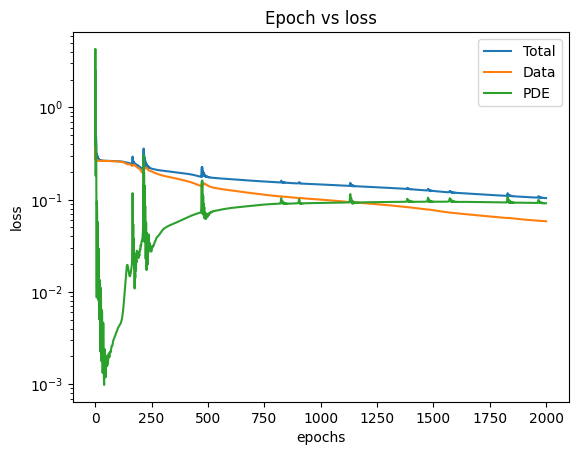

Train end


Test MSE Loss :  0.3482874290092148


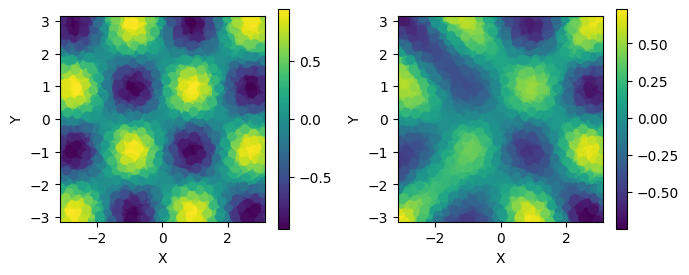

training with A:1.302736759185791 B:0.5521091222763062 C:1.4942715167999268
Epoch 0/2000, Total Loss: 0.5162885785102844, Data Loss: 0.4773293435573578, PDE Loss: 0.07791851460933685, LR: 0.02
Epoch 50/2000, Total Loss: 0.44997209310531616, Data Loss: 0.44233810901641846, PDE Loss: 0.015267974697053432, LR: 0.013999999999999999
Epoch 100/2000, Total Loss: 0.17483770847320557, Data Loss: 0.10157762467861176, PDE Loss: 0.14652018249034882, LR: 0.006859999999999998
Epoch 150/2000, Total Loss: 0.058223433792591095, Data Loss: 0.01663687638938427, PDE Loss: 0.08317311853170395, LR: 0.006859999999999998
Epoch 200/2000, Total Loss: 0.03117336705327034, Data Loss: 0.010449935682117939, PDE Loss: 0.04144686460494995, LR: 0.006859999999999998
Epoch 250/2000, Total Loss: 0.020145602524280548, Data Loss: 0.006693106610327959, PDE Loss: 0.026904992759227753, LR: 0.004801999999999998
Epoch 300/2000, Total Loss: 0.011818901635706425, Data Loss: 0.0034006701316684484, PDE Loss: 0.016836462542414665, L

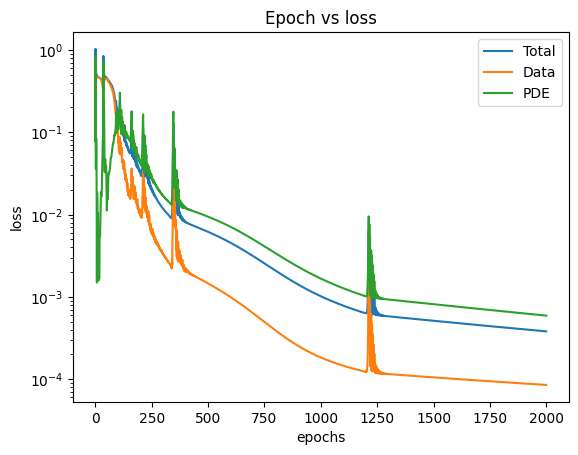

Train end


Test MSE Loss :  0.06717636459575826


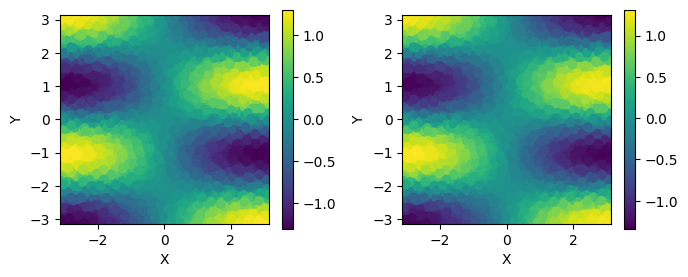

In [11]:
for task in tasks:
    ABC = task.split("_")[1:4]
    A = torch.tensor(float(ABC[0]), dtype=torch.float)
    B = torch.tensor(float(ABC[1]), dtype=torch.float)
    C = torch.tensor(float(ABC[2]), dtype=torch.float)
    
    # 데이터를 준비합니다.
    with open(task, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x_data = data.T[0]
    y_data = data.T[1]
    f_data = A*np.sin(B*x_data) * np.sin(C*y_data)
    xy_data = np.stack([x_data.ravel(), y_data.ravel()], axis=-1)
    xy_data = torch.tensor(xy_data, dtype=torch.float)
    f_data = torch.tensor(f_data.ravel(), dtype=torch.float).view(-1, 1)

    A = A.to(device)
    B = B.to(device)
    C = C.to(device)
    # 데이터 로더를 생성합니다.
    loader = create_dataloader(xy_data, f_data, batch_size, shuffle)

    # 모델을 GPU로 이동합니다(만약 사용 가능하다면).
    model = NN()
    model.load_state_dict(torch.load("./data/model.pt"))
    model = model.to(device)
    # loss
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)

    # init
    loss_history = []
    data_loss_history = []
    pde_loss_history = []
    best_loss = float('inf')
    
    #### 훈련 시작 ####
    print(f"training with A:{A} B:{B} C:{C}")
    model = train_model(model, epochs, A=A, B=B, C=C)
    print("Train end\n\n")
    torch.save(model.state_dict(), f"./data/model_{ABC[0]}_{ABC[1]}_{ABC[1]}.pt")
    test_inference(model, task)